In [31]:
import json
from rdkit import Chem
import pandas as pd

DATA_PATH = '../../data/B-create-dataset/multi-chain-all-biolip-ligands'
DATASET_PATH = f'{DATA_PATH}/dataset.json'
BIOLIP_LIGANDS_PATH = f'{DATA_PATH}/ligand.tsv'

def get_ligand_atom_count(smiles):
    # hint: https://chemistry.stackexchange.com/questions/43363/how-to-calculate-hydrogen-from-smiles-string

    for i in str(smiles.values[0]).split(';'):
        i = i.strip()
        try:
            molecule = Chem.MolFromSmiles(i)
            atoms_count = molecule.GetNumHeavyAtoms()
            return atoms_count, i
        except:
            continue
    return -1, -1

def get_ligand_lengths(dataset_path, ligands_path):
    ligands_df = pd.read_csv(ligands_path, sep='\t')
    
    with open(dataset_path, 'r') as f:
        ds = json.load(f)

    structures = []

    for apo_key, holo_structures in ds.items():
        for holo_structure in holo_structures:
            structure = {}
            structure['apo_structure'] = apo_key + holo_structure['apo_chain']
            structure['holo_structure'] = holo_structure['holo_pdb_id'] + holo_structure['holo_chain']
            ligand = holo_structure['ligand']
            structure['ligand'] = ligand
            atoms_count, smiles = get_ligand_atom_count(ligands_df[ligands_df['#CCD'] == ligand]['SMILES'])
            if atoms_count == -1:
                continue
            structure['ligand_heavy_atom_count'], structure['ligand_smiles'] = atoms_count, smiles
            structures.append(structure)
    return pd.DataFrame(structures)

ligand_lengths = get_ligand_lengths(DATASET_PATH, BIOLIP_LIGANDS_PATH)


[15:12:36] Explicit valence for atom # 16 O, 3, is greater than permitted
[15:12:37] Explicit valence for atom # 0 O, 3, is greater than permitted
[15:12:37] SMILES Parse Error: syntax error while parsing: S1|2[Fe]|3S4|[Fe]15S[Fe]67S|8[Mo]9|S%10[Fe]%11|8S[Fe]%12|2S|3[Fe]4%13S[Fe]%10(|S69)[C]57%11%12%13
[15:12:37] SMILES Parse Error: Failed parsing SMILES 'S1|2[Fe]|3S4|[Fe]15S[Fe]67S|8[Mo]9|S%10[Fe]%11|8S[Fe]%12|2S|3[Fe]4%13S[Fe]%10(|S69)[C]57%11%12%13' for input: 'S1|2[Fe]|3S4|[Fe]15S[Fe]67S|8[Mo]9|S%10[Fe]%11|8S[Fe]%12|2S|3[Fe]4%13S[Fe]%10(|S69)[C]57%11%12%13'
[15:12:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:12:40] Explicit valence for atom # 0 Be, 3, is greater than permitted
[15:12:40] Explicit valence for atom # 21 Be, 3, is greater than permitted
[15:12:40] Explicit valence for atom # 0 Be, 3, is greater than permitted
[15:12:40] Explicit valence for atom # 21 Be, 3, is greater than permitted
[15:12:40] Explicit valence for atom # 0 Be, 3, is greater th

In [32]:
ligand_lengths.to_csv('./data/ligand_length.csv')

In [35]:
sum(ligand_lengths['ligand_heavy_atom_count'] == 1)

832

Text(0.5, 0, '# of ligands')

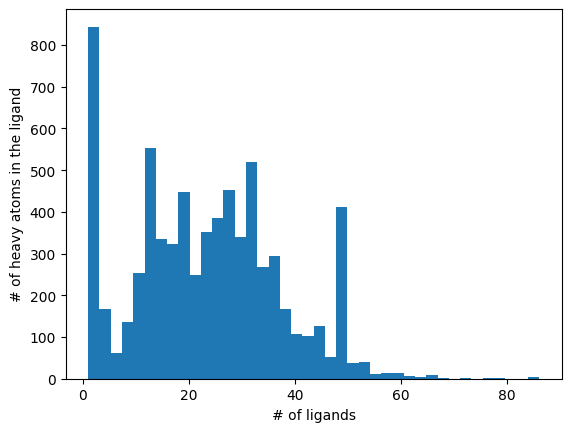

In [39]:
import matplotlib.pyplot as plt
plt.hist(ligand_lengths['ligand_heavy_atom_count'], bins=40)  # density=False would make counts
plt.ylabel('# of heavy atoms in the ligand')
plt.xlabel('# of ligands')
